### Objective

In this notebook, we attempt to build surrogate models for predicting the thermal resistance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb
import sklearn.gaussian_process as gp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, max_error

# Custom Gaussian Process model
GP_path = os.path.abspath(os.path.join('../../'))
if GP_path not in sys.path:
    sys.path.append(GP_path+"\\GaussianProcess")
from GPInterpolator import GPInterpolator

import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

### 1. Load dataset

In [2]:
df = pd.read_csv('./Dataset/TcTj_train.csv', header=None)
df.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']
print(f"Pool: {df.shape[0]}")

Pool: 9421


In [3]:
# Remove outliers
df = df[df.Tj<250].reset_index(drop=True)
print(f"Filtered pol: {df.shape[0]}")

Filtered pol: 9386


In [4]:
# Dedicated testing set
df_test = pd.read_csv('./Dataset/TcTj_test.csv', header=None)
df_test.columns = ['Q1', 'Q2', 'd', 'b', 'L', 'c', 'L_duct', 'n', 't', 'xc1', 'yc1', 'xc2', 'yc2', 'Tc', 'Tj', 'w']

# Remove outliers
df_test = df_test[df_test.Tj<250].reset_index(drop=True)
print(f"Filtered testing pol: {df_test.shape[0]}")

Filtered testing pol: 9375


In [5]:
def create_samples(df, train_num):
   
    # Create dataset
    X = df.iloc[:, :-3].to_numpy()
    y = df.iloc[:, -2].to_numpy()
    
    # Train-test split
    if train_num < len(df):
        test_size = 1-train_num/len(df)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None
    
    return X_train, X_test, y_train, y_test

In [6]:
# Train-test split
X_train, _, y_train, _ = create_samples(df, 9000)
X_test, _, y_test, _ = create_samples(df_test, 9000)

### 2. Model training

In [7]:
def evaluate_model(y_true, y_pred):
    """This function is used for evaluating the ML models performance."""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    max_e = max_error(y_true, y_pred)
    
    percentage = np.abs(y_true-y_pred)/y_true
    max_percentage = np.max(percentage)*100
    max_percentage_loc = np.argmax(percentage)
    mean_percentage = np.mean(percentage)*100
    
    return rmse, max_e, max_percentage, max_percentage_loc, mean_percentage

#### GPflow version (with random initialization)

In [ ]:
from scipy.stats import qmc

# Create initial samples
n_restarts = 10
lb, ub = -3, 3
lhd = qmc.LatinHypercube(d=X_train.shape[1], seed=42).random(n_restarts)
length_scale = (ub-lb)*lhd + lb
length_scale = np.sqrt(1/(2*10**length_scale))

In [ ]:
# Normalization
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)

In [ ]:
%%time

models = []
log_likelihoods = []

with tf.device("CPU:0"):

    for i, init in enumerate(length_scale):
        print(f"Performing {i+1}-th optimization:")

        # Set up the kernel
        kernel = gpflow.kernels.SquaredExponential(variance=np.var(y_train), lengthscales=init)
        model = gpflow.models.GPR(
            (X_train_norm, y_train.reshape(-1, 1)),
            kernel=kernel,
            mean_function=gpflow.functions.Polynomial(0)
        )
        
        opt = gpflow.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
    
        models.append(model)
        log_likelihoods.append(model.log_marginal_likelihood().numpy())

# Select the model with the highest log-marginal likelihood
best_model_index = np.argmax(log_likelihoods)
best_model = models[best_model_index]

print(f"Best model log-marginal likelihood: {log_likelihoods[best_model_index]}")

In [ ]:
gpflow.utilities.print_summary(best_model)

In [ ]:
X_test_norm = scaler.transform(X_test)
f_mean, _ = best_model.predict_f(X_test_norm, full_cov=False)
    
rmse, max_e, max_per, _, mean_per = evaluate_model(y_test, f_mean.numpy().flatten())
print(f"RMSE: {rmse:.4f} / data std: {np.std(y_test):.4f}")
print(f"Max Error: {max_e:.4f}")
print(f"Max Percentage Error: {max_per:.2f}")
print(f"Mean Percentage Error: {mean_per:.2f}")

In [ ]:
# Set the default font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y_test, f_mean.numpy().flatten(), 'o')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')

plt.tight_layout()

#### Sparse Gaussian Process

In [8]:
from scipy.stats import qmc

# Create initial samples
n_restarts = 10
lb, ub = -3, 3
lhd = qmc.LatinHypercube(d=X_train.shape[1], seed=42).random(n_restarts)
length_scale = (ub-lb)*lhd + lb
length_scale = np.sqrt(1/(2*10**length_scale))

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)

In [9]:
from sklearn.neighbors import NearestNeighbors

def sample_creator(X, sample_num, sampling_scheme='LHS'):
    """Space-filling sampling for inducing points.

    Args:
    -----
    - X: the full training dataset
    - sample_num: the number of training samples
    - sampling_scheme: the sampling scheme
    - verbose: print the information
    """
    
    # Create virtual samples
    if sampling_scheme == 'LHS':
        raw_virtual_samples = qmc.LatinHypercube(d=X.shape[1]).random(n=sample_num)
    elif sampling_scheme == 'Halton':
        raw_virtual_samples = qmc.Halton(d=X.shape[1]).random(sample_num)
    else:
        raise ValueError(f"Invalid sampling scheme: {sampling_scheme}")

    # Dataset statistics
    X_scaled = MinMaxScaler().fit_transform(X)

    # Find closest real samples
    sample_finder = NearestNeighbors(n_neighbors=1).fit(X_scaled)
    _, indices = sample_finder.kneighbors(raw_virtual_samples)
    
    # Drop duplicates
    train_indices = np.unique(indices)

    # Compose train & pool samples
    X_induce = X[train_indices.flatten()]
  
    return X_induce

In [10]:
class T_adjustment(gpflow.functions.MeanFunction):
    def __call__(self, X: gpflow.base.TensorType) -> tf.Tensor:
        return 0.117*X[:, 0:1]

In [11]:
%%time

models = []
loss = []
induce_points_num = 300

with tf.device("CPU:0"):

    for i, init in enumerate(length_scale):
        print(f"Performing {i+1}-th optimization:")

        # Generate induce points
        X_induce = sample_creator(X_train, induce_points_num, sampling_scheme='Halton')
        X_induce_norm = scaler.transform(X_induce)

        # Set up the kernel
        kernel = gpflow.kernels.SquaredExponential(variance=np.var(y_train), lengthscales=init)
        model = gpflow.models.SGPR(
            (X_train_norm, y_train.reshape(-1, 1)),
            kernel=kernel,
            inducing_variable=X_induce_norm,
            mean_function=gpflow.functions.Polynomial(0) + T_adjustment()
        )
        
        opt = gpflow.optimizers.Scipy()
        loss_closure = model.training_loss_closure(compile=True)
        opt.minimize(loss_closure, model.trainable_variables, options=dict(maxiter=100))
    
        models.append(model)
        loss.append(loss_closure().numpy())

# Select the model with the highest log-marginal likelihood
best_model_index = np.argmin(loss)
best_model = models[best_model_index]

print(f"Best model loss: {loss[best_model_index]}")

Performing 1-th optimization:
Performing 2-th optimization:
Performing 3-th optimization:
Performing 4-th optimization:
Performing 5-th optimization:
Performing 6-th optimization:
Performing 7-th optimization:
Performing 8-th optimization:
Performing 9-th optimization:
Performing 10-th optimization:
Best model loss: 29427.48421475343
CPU times: total: 28min 40s
Wall time: 4min 23s


In [12]:
X_test_norm = scaler.transform(X_test)
f_mean, _ = best_model.predict_f(X_test_norm, full_cov=False)
    
rmse, max_e, max_per, _, mean_per = evaluate_model(y_test, f_mean.numpy().flatten())
print(f"RMSE: {rmse:.4f} / data std: {np.std(y_test):.4f}")
print(f"Max Error: {max_e:.4f}")
print(f"Max Percentage Error: {max_per:.2f}")
print(f"Mean Percentage Error: {mean_per:.2f}")

RMSE: 5.2616 / data std: 29.8499
Max Error: 59.1256
Max Percentage Error: 31.06
Mean Percentage Error: 3.04


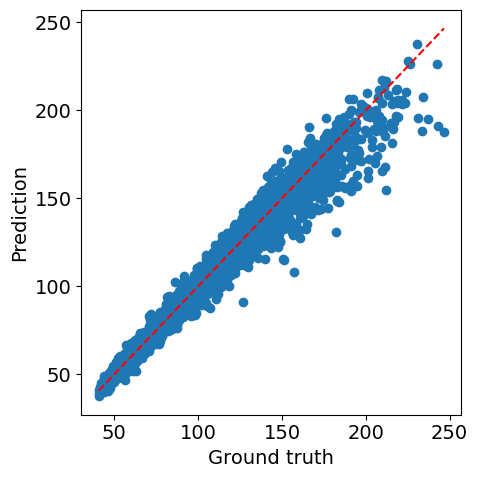

In [13]:
# Set the default font size
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(y_test, f_mean.numpy().flatten(), 'o')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax.set_xlabel('Ground truth')
ax.set_ylabel('Prediction')

plt.tight_layout()